In [1]:

# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [3]:
import pandas as pd

# Step 1: Load datasets
print("\n" + "="*60)
print("STEP 1: Loading Data")
print("="*60)

# Load social media profile data
social_data = pd.read_csv('customer_social_profiles.csv')
print(f"Social profile data loaded: {social_data.shape[0]} rows, {social_data.shape[1]} columns")

# Load customer purchase/support data
purchase_data = pd.read_csv('customer_transactions.csv', on_bad_lines='skip')
print(f"Purchase data loaded: {purchase_data.shape[0]} rows, {purchase_data.shape[1]} columns")

# Step 2: Standardize ID columns
# Rename columns to a common name
if 'customer_id_new' in social_data.columns:
    social_data.rename(columns={'customer_id_new': 'customer_id'}, inplace=True)

if 'customer_id_legacy' in purchase_data.columns:
    purchase_data.rename(columns={'customer_id_legacy': 'customer_id'}, inplace=True)

# Convert IDs to string to avoid type mismatch
social_data['customer_id'] = social_data['customer_id'].astype(str)
purchase_data['customer_id'] = purchase_data['customer_id'].astype(str)

print("Social data columns after rename:", social_data.columns.tolist())
print("Purchase data columns after rename:", purchase_data.columns.tolist())

# Step 3: Merge datasets
merged_data = pd.merge(social_data, purchase_data, on='customer_id', how='inner')
print(f"Merged data: {merged_data.shape[0]} rows, {merged_data.shape[1]} columns")

# Step 4: Save merged CSV
merged_csv_path = 'merged_customer_data.csv'
merged_data.to_csv(merged_csv_path, index=False)
print(f"Merged data saved to {merged_csv_path}")



STEP 1: Loading Data
Social profile data loaded: 155 rows, 5 columns
Purchase data loaded: 150 rows, 6 columns
Social data columns after rename: ['customer_id', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment']
Purchase data columns after rename: ['customer_id', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating']
Merged data: 0 rows, 10 columns
Merged data saved to merged_customer_data.csv


In [4]:
print("Columns in merged_data:")
print(merged_data.columns)


Columns in merged_data:
Index(['customer_id', 'social_media_platform', 'engagement_score',
       'purchase_interest_score', 'review_sentiment', 'transaction_id',
       'purchase_amount', 'purchase_date', 'product_category',
       'customer_rating'],
      dtype='object')


In [5]:
# Step 3: Data Exploration
print("\n" + "="*60)
print("STEP 3: Data Exploration")
print("="*60)

print("\nSocial Profile Data - First 5 rows:")
print(social_data.head())

print("\nPurchase Data - First 5 rows:")
print(purchase_data.head())

print("\nMerged Customer Data - First 5 rows:")
print(merged_data.head())

print("\nSocial Profile Data Info:")
print(social_data.info())

print("\nPurchase Data Info:")
print(purchase_data.info())

print("\nMerged Customer Data Info:")
print(merged_data.info())

# Optional: check for missing values
print("\nMissing values in merged data:")
print(merged_data.isnull().sum())



STEP 3: Data Exploration

Social Profile Data - First 5 rows:
  customer_id social_media_platform  engagement_score  \
0        A178              LinkedIn                74   
1        A190               Twitter                82   
2        A150              Facebook                96   
3        A162               Twitter                89   
4        A197               Twitter                92   

   purchase_interest_score review_sentiment  
0                      4.9         Positive  
1                      4.8          Neutral  
2                      1.6         Positive  
3                      2.6         Positive  
4                      2.3          Neutral  

Purchase Data - First 5 rows:
  customer_id  transaction_id  purchase_amount purchase_date product_category  \
0         151            1001              408    2024-01-01           Sports   
1         192            1002              332    2024-01-02      Electronics   
2         114            1003              4

In [6]:
# Step 4: Data Preprocessing
print("\n" + "="*60)
print("STEP 4: Data Preprocessing")
print("="*60)

# Check columns
print("Social data columns:", social_data.columns.tolist())
print("Purchase data columns:", purchase_data.columns.tolist())

# Handle missing values in purchase data
print(f"\nMissing values in purchase data before handling:\n{purchase_data.isnull().sum()}")
purchase_data['customer_rating'] = purchase_data['customer_rating'].fillna(
    purchase_data['customer_rating'].median()
)
print("✓ Missing values handled")

# Standardize customer IDs for merging
# Adjust column names depending on your CSV
social_id_col = 'customer_id_new' if 'customer_id_new' in social_data.columns else social_data.columns[0]
purchase_id_col = 'customer_id_legacy' if 'customer_id_legacy' in purchase_data.columns else purchase_data.columns[0]

social_data['customer_id'] = social_data[social_id_col].astype(str).str.replace('A', '', regex=True).astype(int)
purchase_data['customer_id'] = purchase_data[purchase_id_col].astype(int)

print("✓ Customer IDs standardized for merging")



STEP 4: Data Preprocessing
Social data columns: ['customer_id', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment']
Purchase data columns: ['customer_id', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating']

Missing values in purchase data before handling:
customer_id          0
transaction_id       0
purchase_amount      0
purchase_date        0
product_category     0
customer_rating     10
dtype: int64
✓ Missing values handled
✓ Customer IDs standardized for merging


In [7]:
print("\n" + "="*60)
print("STEP 5: Feature Engineering")
print("="*60)

# Ensure customer_id exists in both datasets
if 'customer_id' not in social_data.columns:
    raise KeyError("social_data does not have 'customer_id'")
if 'customer_id' not in purchase_data.columns:
    raise KeyError("purchase_data does not have 'customer_id'")

# Aggregate social media features per customer
social_agg = social_data.groupby('customer_id').agg({
    'engagement_score': 'mean',
    'purchase_interest_score': 'mean',
    'review_sentiment': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Neutral'
}).reset_index()

print("✓ Social media features aggregated per customer")

# Aggregate purchase history features per customer
purchase_agg = purchase_data.groupby('customer_id').agg({
    'purchase_amount': ['mean', 'sum', 'count'],
    'customer_rating': 'mean',
    'product_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Flatten multi-level columns
purchase_agg.columns = ['customer_id', 'avg_purchase_amount', 'total_spent',
                        'purchase_count', 'avg_rating', 'most_purchased_category']

print("✓ Purchase history aggregated per customer")

# Merge aggregated features into a single dataset
merged_data = pd.merge(social_agg, purchase_agg, on='customer_id', how='inner')
print(f"✓ Merged aggregated features: {merged_data.shape[0]} rows, {merged_data.shape[1]} columns")

# Optional: Save for later use
merged_data.to_csv('merged_customer_data.csv', index=False)
print("✓ Merged customer data saved to 'merged_customer_data.csv'")



STEP 5: Feature Engineering
✓ Social media features aggregated per customer
✓ Purchase history aggregated per customer
✓ Merged aggregated features: 61 rows, 9 columns
✓ Merged customer data saved to 'merged_customer_data.csv'


In [ ]:
# Step 6: Confirm merged dataset
print("\n" + "="*60)
print("STEP 6: Confirm Merged Dataset")
print("="*60)

# Check that merged_data exists
if 'merged_data' not in locals():
    raise ValueError("Merged dataset not found. Please run Step 5 first.")

print(f"✓ Merged dataset contains: {merged_data.shape[0]} customers and {merged_data.shape[1]} features")

print("\nMerged data preview (first 5 rows):")
print(merged_data.head())

# Optional: Save again to ensure downstream steps can access it
merged_data.to_csv('merged_customer_data.csv', index=False)
print("✓ Merged customer data saved to 'merged_customer_data.csv'")



STEP 6: Confirm Merged Dataset
✓ Merged dataset contains: 61 customers and 9 features

Merged data preview (first 5 rows):
   customer_id  engagement_score  purchase_interest_score review_sentiment  \
0          100         77.000000                 4.400000         Negative   
1          101         68.000000                 1.000000          Neutral   
2          102         51.000000                 4.800000          Neutral   
3          103         64.333333                 2.866667         Positive   
4          104         83.000000                 2.933333         Negative   

   avg_purchase_amount  total_spent  purchase_count  avg_rating  \
0           279.500000         1118               4    4.300000   
1           254.000000         2032               8    2.525000   
2           189.666667         1138               6    3.433333   
3           265.666667         1594               6    4.200000   
4           349.000000         1396               4    1.450000   

  mo

In [8]:
# Step 7: Encode categorical variables
print("\n" + "="*60)
print("STEP 7: Encoding Categorical Features")
print("="*60)

from sklearn.preprocessing import LabelEncoder

# --- Encode review sentiment ---
if 'review_sentiment' in merged_data.columns:
    le_sentiment = LabelEncoder()
    merged_data['review_sentiment_encoded'] = le_sentiment.fit_transform(merged_data['review_sentiment'])
    print(f"✓ Sentiment classes encoded: {list(le_sentiment.classes_)}")
else:
    raise KeyError("'review_sentiment' column not found in merged_data")

# --- Encode target variable (most purchased category) ---
if 'most_purchased_category' in merged_data.columns:
    le_category = LabelEncoder()
    merged_data['category_encoded'] = le_category.fit_transform(merged_data['most_purchased_category'])
    print(f"✓ Product categories encoded: {list(le_category.classes_)}")
else:
    raise KeyError("'most_purchased_category' column not found in merged_data")



STEP 7: Encoding Categorical Features
✓ Sentiment classes encoded: ['Negative', 'Neutral', 'Positive']
✓ Product categories encoded: ['Books', 'Clothing', 'Electronics', 'Groceries', 'Sports']


In [12]:
print("\n" + "="*60)
print("STEP 8: Preparing Features and Target")
print("="*60)

# Define feature columns
feature_columns = [
    'engagement_score',
    'purchase_interest_score',
    'review_sentiment_encoded',
    'avg_purchase_amount',
    'total_spent',
    'purchase_count',
    'avg_rating'
]

# Ensure all feature columns exist in the dataframe
missing_features = [col for col in feature_columns if col not in merged_data.columns]
if missing_features:
    raise KeyError(f"The following feature columns are missing in merged_data: {missing_features}")

# Prepare feature matrix X and target vector y
X = merged_data[feature_columns]
y = merged_data['category_encoded']

print(f"✓ Features matrix X shape: {X.shape}")
print(f"✓ Target vector y shape: {y.shape}")
print(f"✓ Feature columns: {feature_columns}")


STEP 8: Preparing Features and Target
✓ Features matrix X shape: (61, 7)
✓ Target vector y shape: (61,)
✓ Feature columns: ['engagement_score', 'purchase_interest_score', 'review_sentiment_encoded', 'avg_purchase_amount', 'total_spent', 'purchase_count', 'avg_rating']


In [26]:
from sklearn.model_selection import train_test_split

print("\n" + "="*60)
print("STEP 9: Splitting Data")
print("="*60)

# Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"✓ Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"✓ Target distribution in training set:\n{y_train.value_counts()}")
print(f"✓ Target distribution in testing set:\n{y_test.value_counts()}")


STEP 9: Splitting Data
✓ Training set: 48 samples, 7 features
✓ Testing set: 13 samples, 7 features
✓ Target distribution in training set:
category_encoded
2    14
1    11
0    11
3     6
4     6
Name: count, dtype: int64
✓ Target distribution in testing set:
category_encoded
2    4
0    3
1    3
4    2
3    1
Name: count, dtype: int64


In [14]:
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*60)
print("STEP 10: Training Random Forest Model")
print("="*60)

# Initialize Random Forest classifier
model = RandomForestClassifier(
    n_estimators=100,   # Number of trees
    max_depth=10,       # Limit tree depth to prevent overfitting
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Confirm training
print("✓ Model training complete!")



STEP 10: Training Random Forest Model
✓ Model training complete!


In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n" + "="*60)
print("STEP 11: Making Predictions")
print("="*60)

# Generate predictions on the test set
y_pred = model.predict(X_test)

print(f"✓ Predictions generated for {X_test.shape[0]} test samples")



STEP 11: Making Predictions
✓ Predictions generated for 13 test samples


In [17]:
# Step 12: Evaluate the model
print("\n" + "="*60)
print("STEP 12: Model Evaluation")
print("="*60)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_category.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


STEP 12: Model Evaluation

Model Accuracy: 38.46%

Classification Report:
              precision    recall  f1-score   support

       Books       0.20      0.33      0.25         3
    Clothing       0.25      0.33      0.29         3
 Electronics       0.75      0.75      0.75         4
   Groceries       0.00      0.00      0.00         1
      Sports       0.00      0.00      0.00         2

    accuracy                           0.38        13
   macro avg       0.24      0.28      0.26        13
weighted avg       0.33      0.38      0.35        13


Confusion Matrix:
[[1 2 0 0 0]
 [1 1 1 0 0]
 [1 0 3 0 0]
 [1 0 0 0 0]
 [1 1 0 0 0]]


In [18]:
import joblib

# --- 13. SAVE THE TRAINED MODEL AND LABEL ENCODER ---

# Save the trained product recommendation model
model_filename = 'product_recommendation_model.pkl'
joblib.dump(model, model_filename)
print(f"Trained model saved to: {model_filename}")

# Save the Label Encoder for categories
encoder_filename = 'product_category_encoder.pkl'
joblib.dump(le_category, encoder_filename)
print(f"Label Encoder saved to: {encoder_filename}")


Trained model saved to: product_recommendation_model.pkl
Label Encoder saved to: product_category_encoder.pkl



Feature Importance Ranking:
                    feature  importance
4               total_spent    0.215492
3       avg_purchase_amount    0.178203
1   purchase_interest_score    0.172032
0          engagement_score    0.157139
6                avg_rating    0.149293
5            purchase_count    0.066047
2  review_sentiment_encoded    0.061794


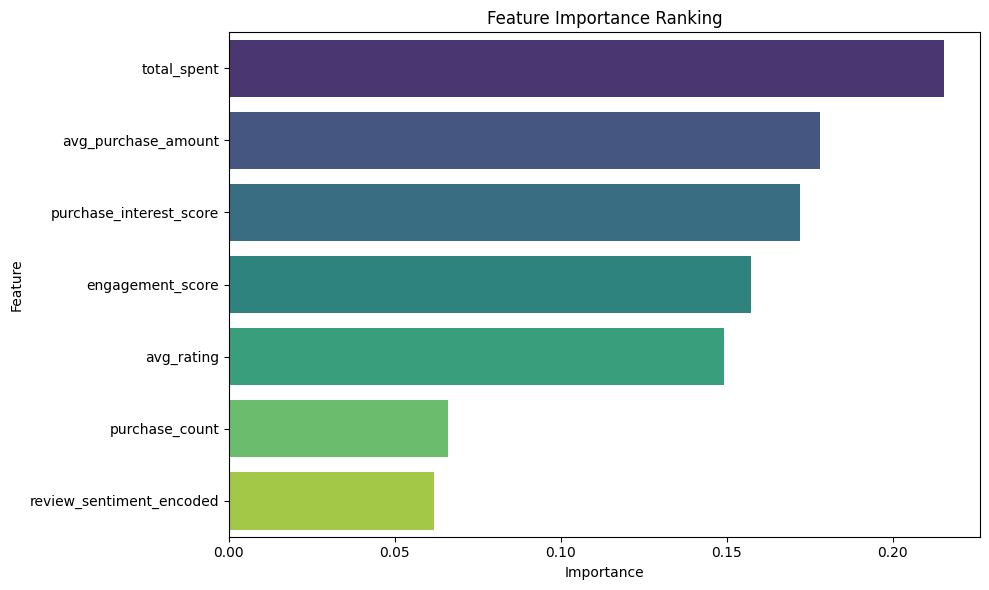

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure your trained model and feature columns are available
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [31]:
def recommend_category(top_n=3):
    """
    Recommend product categories for all customers.

    Parameters:
    - top_n: Number of top categories to recommend per customer

    Returns:
    - DataFrame with customer_id, top recommended categories, and probabilities
    """
    all_recommendations = []

    # Define product_categories using the LabelEncoder's classes
    product_categories = le_category.classes_

    for _, customer_series in merged_data.iterrows():
        # Convert Series to DataFrame
        customer_data = pd.DataFrame([customer_series])

        # Ensure all features are present and fill missing values
        customer_features = customer_data[feature_columns].fillna(0)

        # Predict probabilities
        probabilities = model.predict_proba(customer_features)[0]
        top_indices = np.argsort(probabilities)[::-1][:top_n]

        for i in top_indices:
            all_recommendations.append({
                'customer_id': customer_data['customer_id'].values[0],
                'Category': product_categories[i],
                'Probability': f"{probabilities[i]:.2%}"
            })

    recommendations_df = pd.DataFrame(all_recommendations)
    return recommendations_df


STEP 15: Visualize Product Category Distribution


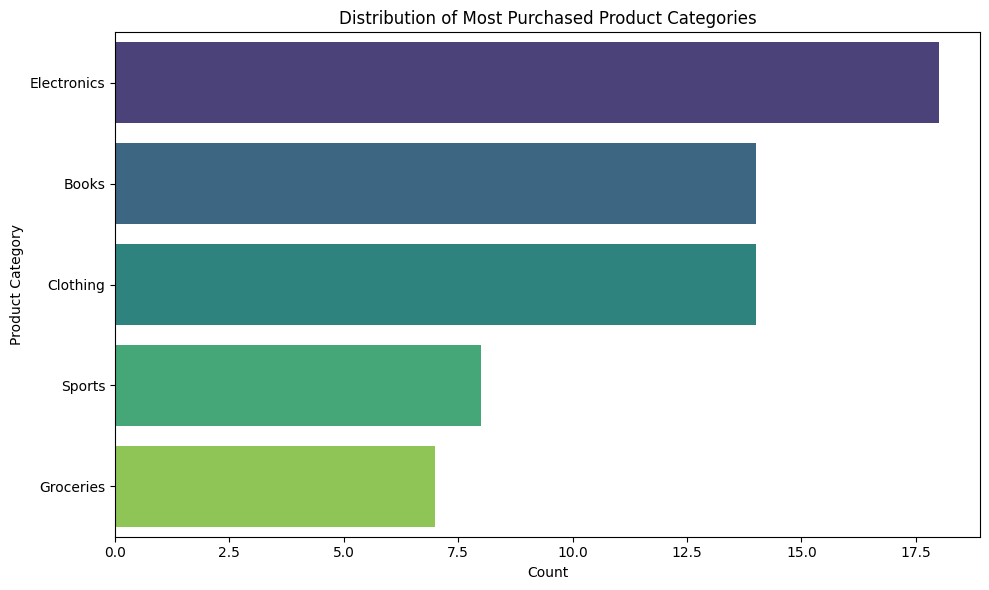

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("STEP 15: Visualize Product Category Distribution")
print("="*60)

plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, y='most_purchased_category', palette='viridis', order = merged_data['most_purchased_category'].value_counts().index)
plt.title('Distribution of Most Purchased Product Categories')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


STEP 16: Plot Confusion Matrix Heatmap


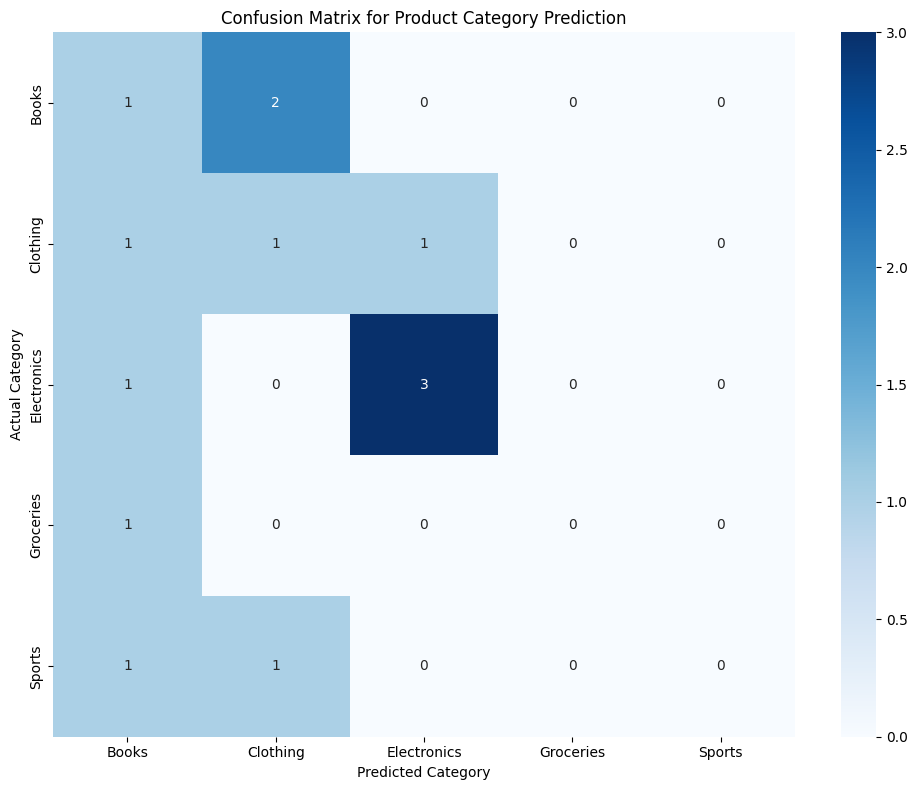

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("STEP 16: Plot Confusion Matrix Heatmap")
print("="*60)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get category names from the label encoder
category_names = le_category.classes_

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix for Product Category Prediction')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.tight_layout()
plt.show()


In [37]:
# Step 17: Test the recommendation system
print("\n" + "="*60)
print("STEP 17: Testing Recommendation System")
print("="*60)

if merged_data.empty:
    print("Error: Merged customer data is empty. Please check previous steps.")
else:
    recommendations_df = recommend_category(top_n=3)
    print("Sample recommendations for first 10 entries:")
    print(recommendations_df.head(10))

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)



STEP 17: Testing Recommendation System
Sample recommendations for first 10 entries:
   customer_id     Category Probability
0          100        Books      69.50%
1          100     Clothing      14.00%
2          100  Electronics       9.50%
3          101        Books      78.00%
4          101    Groceries      11.00%
5          101     Clothing       5.00%
6          102        Books      39.00%
7          102  Electronics      25.00%
8          102     Clothing      23.00%
9          103     Clothing      63.00%

MODEL TRAINING COMPLETE!
